### Load data

In [1]:
import plotly.io as pio

png_renderer = pio.renderers["png"]
png_renderer.width = 1500
png_renderer.height = 700
pio.renderers.default = "png"
pio.templates.default = "plotly_white"

In [2]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import ks_2samp
from tensorflow.keras.utils import to_categorical
from plotly.subplots import make_subplots   
import plotly.graph_objects as go
import numpy as np

df_train = pd.read_csv("train_processed.csv")
df_val = pd.read_csv("val_processed.csv")
df_test = pd.read_csv("test_processed.csv")

In [3]:
df_train.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,not_satisfied_client,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
0,0.205128,0.085622,0.4,0.8,1.0,0.6,0.4,1.0,0.2,0.4,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.371795,0.104806,0.6,0.4,0.4,0.4,0.4,0.4,0.4,0.4,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2,0.358974,0.338853,0.8,0.6,0.8,0.4,0.2,0.8,0.2,0.2,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.551282,0.343700,0.4,0.6,0.6,0.2,0.6,0.4,0.6,0.6,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
4,0.179487,0.142165,0.2,0.8,0.2,0.2,0.4,0.2,0.4,0.4,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [4]:
X_train = df_train.drop('not_satisfied_client', axis=1)
y_train = df_train['not_satisfied_client']

X_val = df_val.drop('not_satisfied_client', axis=1)
y_val = df_val['not_satisfied_client']

X_test = df_test.drop('not_satisfied_client', axis=1)
y_test = df_test['not_satisfied_client']

### Experiments

In [5]:
def evaluate_model(y_test, y_pred):
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate precision, recall, and f1-score
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Calculate AUROC
    auroc = roc_auc_score(y_test, y_pred, multi_class='ovr')

    # Calculate Kolmogorov-Smirnov (KS) test
    group_0 = y_pred[y_test == 0]
    group_1 = y_pred[y_test == 1]

    # Perform the KS test
    ks_statistic, p_value = ks_2samp(group_0, group_1)

    return accuracy, precision, recall, f1, auroc, ks_statistic

In [69]:
experiments = [
    {"n_estimators": 100, "max_depth": 3, "learning_rate": 0.01, "subsample": 0.8, "colsample_bylevel": 0.8, "tree_method": 'hist', "reg_lambda": 0.1},
    {"n_estimators": 200, "max_depth": 5, "learning_rate": 0.005, "subsample": 0.9, "colsample_bylevel": 0.9, "tree_method": 'exact', "reg_lambda": 0.5},
    {"n_estimators": 300, "max_depth": 7, "learning_rate": 0.001, "subsample": 0.7, "colsample_bylevel": 0.7, "tree_method": 'approx', "reg_lambda": 1.0},
    {"n_estimators": 150, "max_depth": 6, "learning_rate": 0.2, "subsample": 0.85, "colsample_bylevel": 0.85, "tree_method": 'hist', "reg_lambda": 0.2},
    {"n_estimators": 250, "max_depth": 4, "learning_rate": 0.01, "subsample": 0.6, "colsample_bylevel": 0.6, "tree_method": 'exact', "reg_lambda": 0.2},
    {"n_estimators": 400, "max_depth": 8, "learning_rate": 0.005, "subsample": 0.75, "colsample_bylevel": 0.75, "tree_method": 'approx', "reg_lambda": 0.8},
    {"n_estimators": 100, "max_depth": 5, "learning_rate": 0.02, "subsample": 0.9, "colsample_bylevel": 0.9, "tree_method": 'hist', "reg_lambda": 0.3},
    {"n_estimators": 350, "max_depth": 6, "learning_rate": 0.03, "subsample": 0.7, "colsample_bylevel": 0.7, "tree_method": 'exact', "reg_lambda": 0.05},
    {"n_estimators": 200, "max_depth": 7, "learning_rate": 0.3, "subsample": 0.65, "colsample_bylevel": 0.65, "tree_method": 'approx', "reg_lambda": 0.4},
    {"n_estimators": 400, "max_depth": 4, "learning_rate": 0.004, "subsample": 1, "colsample_bylevel": 1, "tree_method": 'hist', "reg_lambda": 0.9},
    {"n_estimators": 500, "max_depth": 4, "learning_rate": 0.05, "subsample": 0.75, "colsample_bylevel": 0.75, "tree_method": 'hist', "reg_lambda": 0.8},
    {"n_estimators": 500, "max_depth": 4, "learning_rate": 0.1, "subsample": 0.75, "colsample_bylevel": 0.75, "tree_method": 'hist', "reg_lambda": 0.8},
    {"n_estimators": 1000, "max_depth": 5, "learning_rate": 0.2, "subsample": 0.75, "colsample_bylevel": 0.75, "tree_method": 'hist', "reg_lambda": 0.8},
]


In [70]:
results = []

best_ks_stat = -1
best_model = None

for idx, config in enumerate(experiments):
    model = XGBClassifier(**config, random_state=0)
    history = model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)
    y_pred = model.predict(X_test)

    accuracy, precision, recall, f1, auroc, ks_stat = evaluate_model(y_test, y_pred)
    results.append((idx + 1, config, accuracy, precision, recall, f1, auroc, ks_stat))

    if ks_stat > best_ks_stat:
        best_ks_stat = ks_stat
        best_model = model

In [71]:
results_df = pd.DataFrame(results, columns=['Experiment', 'Config', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUROC', 'KS'])
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

styled_df = results_df.style.apply(highlight_max, subset=['Accuracy', 'Precision', 'Recall', 'F1', 'AUROC', 'KS'])
styled_df

,Experiment,Config,Accuracy,Precision,Recall,F1,AUROC,KS
0,1,"{'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8, 'colsample_bylevel': 0.8, 'tree_method': 'hist', 'reg_lambda': 0.1}",0.894210,0.892413,0.892983,0.892690,0.892983,0.785965
1,2,"{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.005, 'subsample': 0.9, 'colsample_bylevel': 0.9, 'tree_method': 'exact', 'reg_lambda': 0.5}",0.920889,0.922785,0.916683,0.919158,0.916683,0.833366
2,3,"{'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.001, 'subsample': 0.7, 'colsample_bylevel': 0.7, 'tree_method': 'approx', 'reg_lambda': 1.0}",0.933439,0.940460,0.926781,0.931514,0.926781,0.853562
3,4,"{'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.2, 'subsample': 0.85, 'colsample_bylevel': 0.85, 'tree_method': 'hist', 'reg_lambda': 0.2}",0.962696,0.963717,0.960611,0.962011,0.960611,0.921222
4,5,"{'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.01, 'subsample': 0.6, 'colsample_bylevel': 0.6, 'tree_method': 'exact', 'reg_lambda': 0.2}",0.931283,0.931295,0.929028,0.930067,0.929028,0.858056
5,6,"{'n_estimators': 400, 'max_depth': 8, 'learning_rate': 0.005, 'subsample': 0.75, 'colsample_bylevel': 0.75, 'tree_method': 'approx', 'reg_lambda': 0.8}",0.953765,0.953958,0.952107,0.952973,0.952107,0.904215
6,7,"{'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.02, 'subsample': 0.9, 'colsample_bylevel': 0.9, 'tree_method': 'hist', 'reg_lambda': 0.3}",0.938443,0.938652,0.936249,0.937348,0.936249,0.872498
7,8,"{'n_estimators': 350, 'max_depth': 6, 'learning_rate': 0.03, 'subsample': 0.7, 'colsample_bylevel': 0.7, 'tree_method': 'exact', 'reg_lambda': 0.05}",0.962119,0.963434,0.959782,0.961402,0.959782,0.919563
8,9,"{'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.3, 'subsample': 0.65, 'colsample_bylevel': 0.65, 'tree_method': 'approx', 'reg_lambda': 0.4}",0.960964,0.961723,0.959038,0.960263,0.959038,0.918077
9,10,"{'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.004, 'subsample': 1, 'colsample_bylevel': 1, 'tree_method': 'hist', 'reg_lambda': 0.9}",0.911149,0.910770,0.908566,0.909572,0.908566,0.817131


### Analysis pos-hoc

In [72]:
y_pred = best_model.predict_proba(X_test)[:, 1]

In [73]:
# fixes much clients with same output

import numpy as np
y_pred += np.random.normal(scale=1e-5, size=len(y_pred))

In [74]:
def plot_target_vs_score(target, scores, quantiles, lower_limit=None):
    eval_df = pd.DataFrame(zip(target, scores), columns=['TARGET', 'SCORE']).sort_values(by='SCORE')

    quantile = pd.qcut(eval_df['SCORE'], quantiles, labels=range(1,1+quantiles))
    eval_df['QUANTILE'] = quantile
    if lower_limit:
        eval_df = eval_df.loc[eval_df['QUANTILE'] > lower_limit]

    chart_df = pd.DataFrame(zip(
      eval_df.groupby('QUANTILE')['TARGET'].mean(), eval_df.groupby('QUANTILE')['TARGET'].size()/eval_df.shape[0]
      ), columns=['TAXA_DE_MAUS', 'POPULACAO'])

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    chart_df = chart_df.dropna()
    # Add traces
    fig.add_trace(
      go.Bar(x=chart_df.index.to_list(), y=chart_df.POPULACAO, name="Representatividade (%)", marker_color='rgba(0, 0, 87, .8)'),
      secondary_y=False,
    )

    fig.add_trace(
      go.Scatter(x=chart_df.index.to_list(), y=chart_df.TAXA_DE_MAUS, name="Média do alvo ponderada pela exposição (%)", marker_color='red'),
      secondary_y=True,
      #labels=dict(x="Decil", y="Representatividade (%)")
    )

    fig.update_xaxes(title_text='Decil da população')
    fig.update_yaxes(title_text='Representatividade (%)', secondary_y=False)
    fig.update_yaxes(title_text='Média do alvo ponderada pela exposição (%)', secondary_y=True)
    fig.update_layout(
      width=1000,height=500,
      legend=dict(orientation="h", xanchor='center', x=0.5, y=-0.2))

    fig.show()

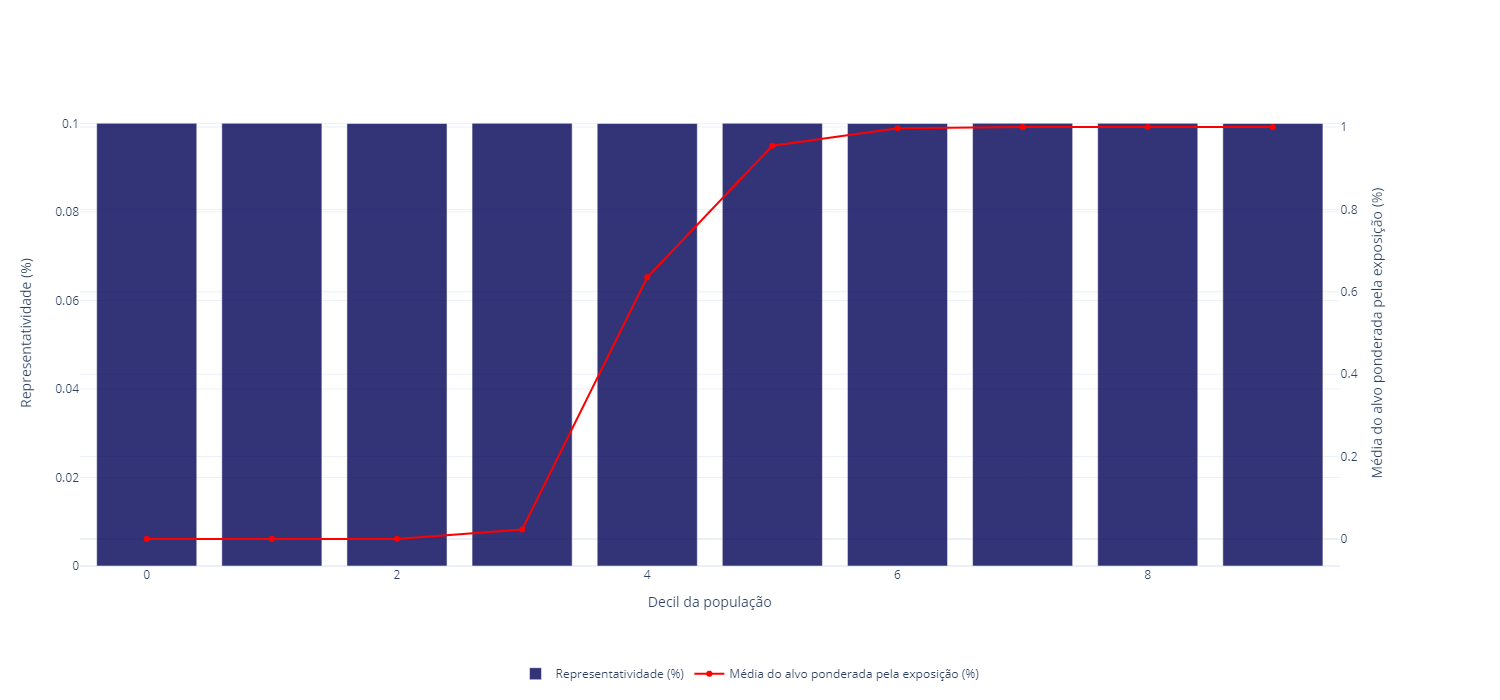

In [75]:
plot_target_vs_score(y_test, y_pred, 10)

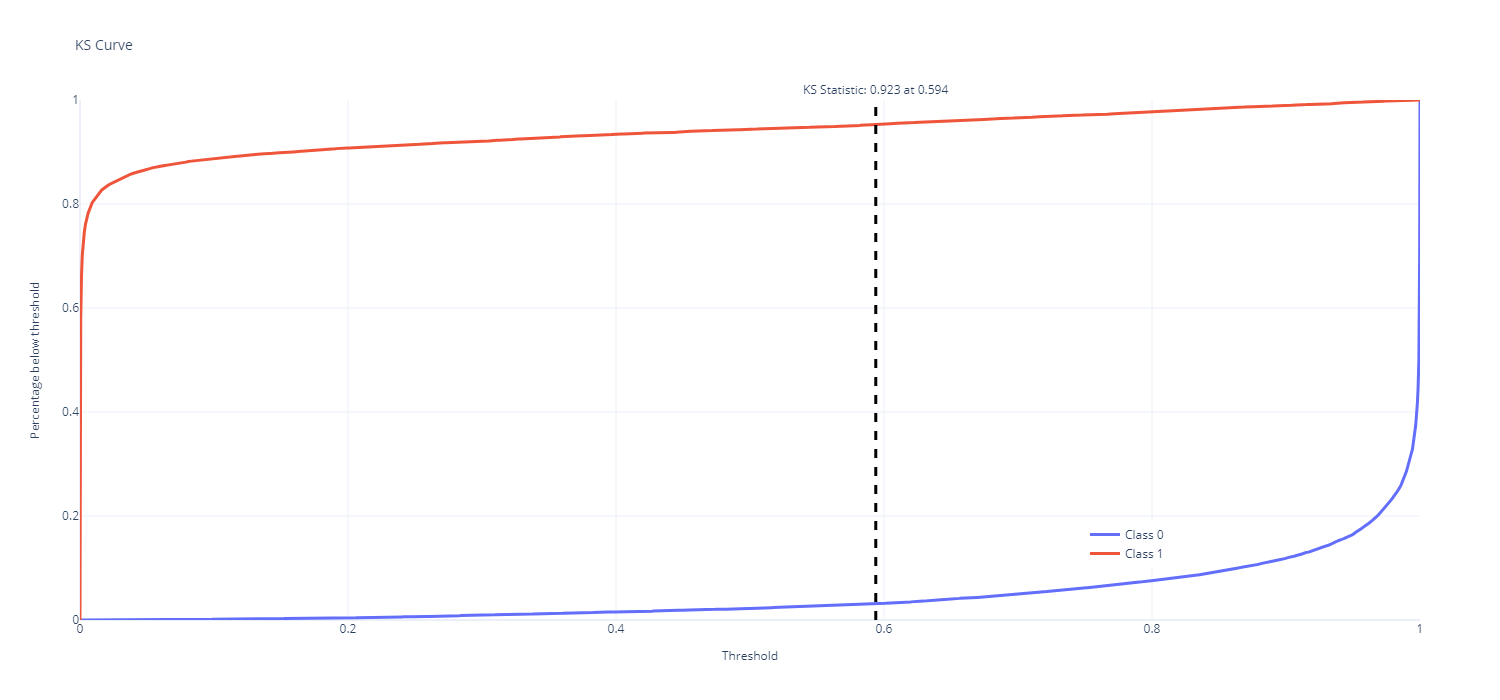

In [76]:
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import roc_curve

def binary_ks_curve(y_true, y_probas):
    # Sort probabilities and true values
    sorted_indices = np.argsort(y_probas)
    sorted_probas = y_probas[sorted_indices]
    sorted_true = y_true[sorted_indices]

    # Compute the cumulative percentage of positives and negatives
    cum_pos = np.cumsum(sorted_true) / np.sum(sorted_true)
    cum_neg = np.cumsum(1 - sorted_true) / np.sum(1 - sorted_true)

    thresholds = np.concatenate([[0], sorted_probas, [1]])
    pct1 = np.concatenate([[0], cum_pos, [1]])
    pct2 = np.concatenate([[0], cum_neg, [1]])

    ks_statistic = np.max(np.abs(pct1 - pct2))
    max_distance_at = thresholds[np.argmax(np.abs(pct1 - pct2))]

    return thresholds, pct1, pct2, ks_statistic, max_distance_at, [0, 1]

def plot_ks_curve(y_true, y_probas, title='KS Curve', title_fontsize=14, text_fontsize=12):
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)

    classes = np.unique(y_true)
    if len(classes) != 2:
        raise ValueError('Cannot calculate KS statistic for data with '
                         '{} category/ies'.format(len(classes)))
    probas = y_probas

    # Compute KS Statistic curves
    thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(y_true, probas.ravel())

    # Create the plotly figure
    fig = go.Figure()

    # Add the percentage below threshold for each class
    fig.add_trace(go.Scatter(x=thresholds, y=pct1, mode='lines', name=f'Class {classes[0]}', line=dict(width=3)))
    fig.add_trace(go.Scatter(x=thresholds, y=pct2, mode='lines', name=f'Class {classes[1]}', line=dict(width=3)))

    # Add the KS Statistic line
    idx = np.where(thresholds == max_distance_at)[0][0]
    fig.add_vline(x=max_distance_at, line_width=3, line_dash='dash', line_color='black',
                  annotation_text=f'KS Statistic: {ks_statistic:.3f} at {max_distance_at:.3f}',
                  annotation_position='top', annotation_font_size=text_fontsize)

    # Update layout
    fig.update_layout(
        title=title, title_font_size=title_fontsize,
        xaxis_title='Threshold', xaxis_title_font_size=text_fontsize,
        yaxis_title='Percentage below threshold', yaxis_title_font_size=text_fontsize,
        xaxis=dict(range=[0.0, 1.0]),
        yaxis=dict(range=[0.0, 1.0]),
        legend=dict(x=0.75, y=0.1, font_size=text_fontsize),
        font=dict(size=text_fontsize)
    )

    return fig

fig = plot_ks_curve(list(y_test), list(y_pred), title='KS Curve')
fig.show()

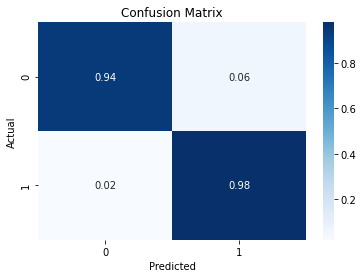

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get confusion matrix
cm = confusion_matrix(y_test, (y_pred > 0.5).astype("int"))
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# Create heatmap
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues")

# Set labels and title
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Show plot
plt.show()


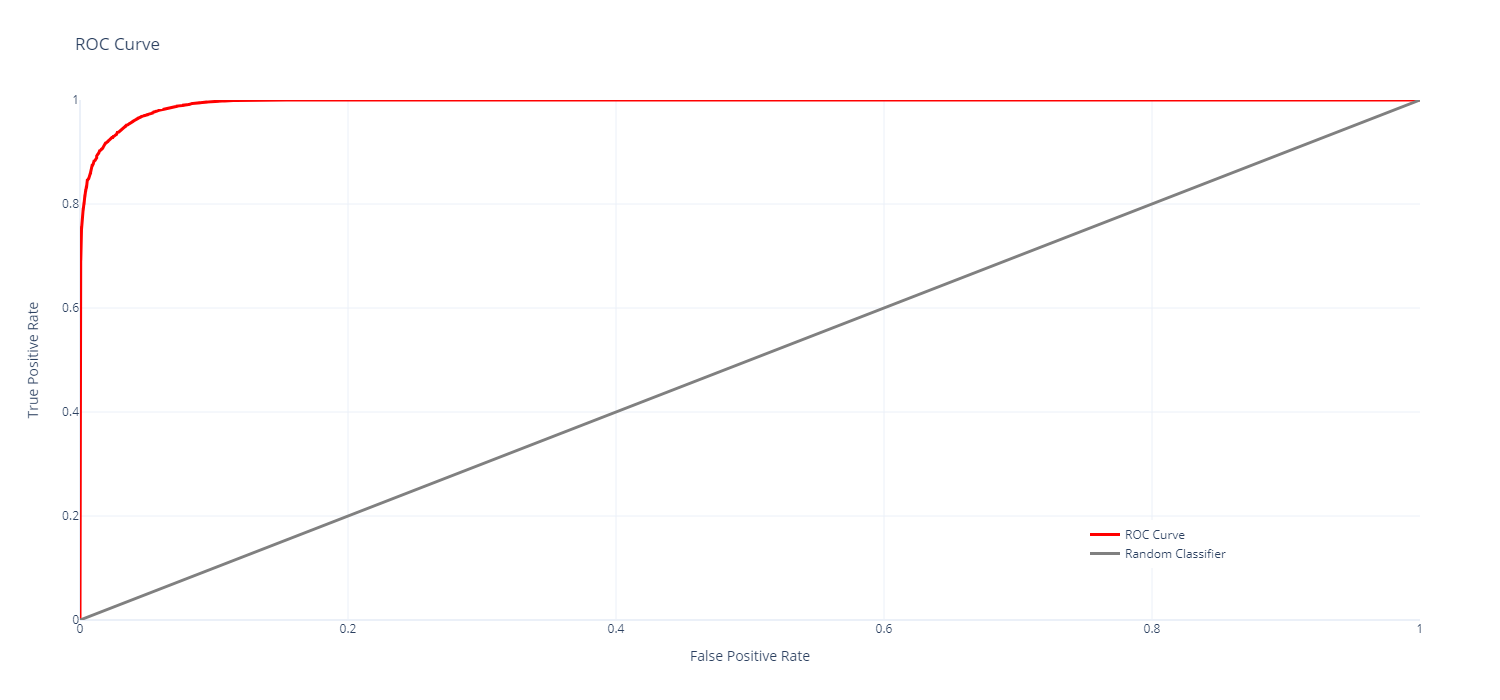

In [78]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Create plotly figure
fig = go.Figure()

# Add ROC curve trace
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC Curve', line=dict(color='red', width=3)))

# Add diagonal line
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Classifier', line=dict(color='grey', width=3)))

# Add annotations

# Update layout
fig.update_layout(
    title='ROC Curve',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    xaxis=dict(range=[0.0, 1.0]),
    yaxis=dict(range=[0.0, 1.0]),
    legend=dict(x=0.75, y=0.1),
    font=dict(size=12),
    width=600,
    height=600
)

# Show plot
fig.show()
